# Deep Learning Final Project: Multimodal Sentiment Analysis

Team Members:
- Mohammadreza Estarki  
ID: 400209184
- Sajad Hosseini  
ID: 400301997
- Kasra Kamali  
ID: 400201648

# Phase Three

In [ ]:
# Upgrade gdown to work properly.
!pip install --upgrade --no-cache-dir gdown
# Install MediaPipe for face detection.
!pip install mediapipe
# Install PyCM for confusion matrix and model evaluation.
!pip install pycm
# Install Hugging Face's transformes. 
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.7/595.7 KB 23.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.9 MB/s eta 0:00:00


In [ ]:
import os
import random
import re
import string
import zipfile
from collections import Counter
from itertools import groupby, product

import gdown
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import pandas as pd
import plotly.express as px
import pycm
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torchvision.models as models
import torchvision.transforms as T
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from tabulate import tabulate
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import GloVe
from torchvision.io import read_image
from torchvision.models import ResNet50_Weights
from torchvision.transforms import (ColorJitter, GaussianBlur,
                                    RandomHorizontalFlip, RandomRotation,
                                    Resize, ToPILImage, ToTensor)
from tqdm.notebook import tqdm
from transformers import (AdamW, AutoProcessor, BertModel, BertTokenizer,
                          CLIPModel, CLIPProcessor,
                          ViltForImagesAndTextClassification, ViltModel,
                          ViltProcessor)
from wordcloud import STOPWORDS, WordCloud

First, we need to download the Multimodal Sentiment Chat Translation Dataset (MSCTD).

In [ ]:
# Download the image dataset.
# train data
# original link
!gdown 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
# alternative link
if not(os.path.isfile('./train_ende.zip')):
    print("Using the alternative link...")
    !gdown 1KlgzJMXqUwGLBP7aQW9C69UDS0bXvDQn


# dev data
# original link
!gdown 12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA
# alternative link
if not(os.path.isfile('./dev.zip')):
    print("Using the alternative link...")
    !gdown 1-4UxUq_KJKyebCM5ngG_F_COSrpO3fEM


# test data
# original link
!gdown 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
# alternative link
if not(os.path.isfile('./test.zip')):
    print("Using the alternative link...")
    !gdown 1--0w9CvsR6aUYmj1AK4K8Yjt9UgdckeZ

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj 

Using the alternative link...
Downloading...
From: https://drive.google.com/uc?id=1KlgzJMXqUwGLBP7aQW9C69UDS0bXvDQn
To: /content/train_ende.zip
100% 2.90G/2.90G [00:19<00:00, 150MB/s]
Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or do

In [ ]:
# Downlaod text files from github.
!git clone https://github.com/XL2248/MSCTD

# Move relevant files to ./data
!mkdir ./data
!mv /content/MSCTD/MSCTD_data/ende /content/data/text

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 19.82 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [ ]:
# Unzip the train images.
zip_ref = zipfile.ZipFile("./train_ende.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

# Unzip the dev images.
zip_ref = zipfile.ZipFile("./dev.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

# Unzip the test images.
zip_ref = zipfile.ZipFile("./test.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

In [ ]:
# Rename train_ende directory to train.
!mv ./data/train_ende ./data/train

# Remove redundant files.
!rm -r MSCTD
!rm ./data/text/german*.txt
!rm train_ende.zip
!rm dev.zip
!rm test.zip

In order to access data more conveniently in the following section, we update our custom dataloader class.

In [ ]:
# Defining the custom dataloader class.
class MSCTD(torch.utils.data.Dataset):
    def __init__(self, data_path, partition, transform=None, target_transform=None, get_mode = 'utterance', shuffle=False, random_seed=None, Auto_Processor=None):
        self.data_path = data_path
        self.partition = partition
        self.imgs_path = os.path.join(data_path, partition)
        self.utterance_path = os.path.join(data_path, 'text', 'english_'+partition+'.txt')
        self.sentiment_path = os.path.join(data_path, 'text', 'sentiment_'+partition+'.txt')
        self.dialogue_path = os.path.join(data_path, 'text', 'image_index_'+partition+'.txt')

        self.transform = transform
        self.target_transform = target_transform
        self.get_mode = get_mode
        self.shuffle = shuffle
        self.Auto_Processor = Auto_Processor

        # Read the utterance indices that form a dialogue for the given partition.
        with open(self.dialogue_path) as f:
            self.dialogue = [np.array(line[1:-2].split(', '), dtype=int) for line in f]
            f.close()

        # Read the English utterances for the given partition.
        with open(self.utterance_path) as f:
            self.utterance = [line.rstrip('\n') for line in f]
        f.close()

        # Read the sentiment labels for the given partition.
        self.sentiment_labels = np.loadtxt(self.sentiment_path, dtype=int)

        # Generate shuffling indices.
        rng = np.random.default_rng(seed=random_seed)
        
        self.shfl_idx_dlg = np.arange(len(self.dialogue))
        rng.shuffle(self.shfl_idx_dlg)

        self.shfl_idx_utt = np.arange(len(self.utterance))
        rng.shuffle(self.shfl_idx_utt)

    def __len__(self):
        if self.get_mode == 'utterance':
            return len(self.utterance)
        elif self.get_mode == 'dialogue':
            return len(self.dialogue)
        elif self.get_mode == 'SOTA':
            return len(self.utterance)
        else:
            return None

    def __getitem__(self, idx):
        if self.get_mode == 'utterance':
            if self.shuffle:
                idx = self.shfl_idx_utt[idx]

            img_path = os.path.join(self.imgs_path, str(idx)+'.jpg')
            image = read_image(img_path)
            utterance = self.utterance[idx]
            sentiment = self.sentiment_labels[idx]

            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                sentiment = self.target_transform(sentiment)

            return image, utterance, sentiment

        elif self.get_mode == 'dialogue':
            if self.shuffle:
                idx = self.shfl_idx_dlg[idx]

            images = []
            utterances = []
            sentiments = []

            for i in self.dialogue[idx]:
                img_path = os.path.join(self.imgs_path, str(i)+'.jpg')
                images.append(read_image(img_path))
                utterances.append(self.utterance[i])
                sentiments.append(self.sentiment_labels[i])

            return images, utterances, sentiments

        elif self.get_mode == 'SOTA':
            if self.shuffle:
                idx = self.shfl_idx_utt[idx]

            img_path = os.path.join(self.imgs_path, str(idx)+'.jpg')
            image = read_image(img_path)
            utterance = self.utterance[idx]
            utterance = utterance.lower()
            sentiment = self.sentiment_labels[idx]
            
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                sentiment = self.target_transform(sentiment)
            
            encoding = self.Auto_Processor(images = image, text = utterance, max_length= 25, padding="max_length", truncation=True, return_tensors="pt")
            # remove batch dimension
            for k,v in encoding.items():
              encoding[k] = v.squeeze()

            encoding["sentiment_label"] = torch.tensor(sentiment)
            return encoding

        else:
            return None

In [ ]:
# Instantiate a MSCTD object for each part of the dataset.
train_data = MSCTD(data_path='./data', partition='train', get_mode='utterance')
dev_data = MSCTD(data_path='./data', partition='dev', get_mode='utterance')
test_data = MSCTD(data_path='./data', partition='test', get_mode='utterance')

## Part 1: Multimodal Learning

### Section 1: Concatenation method

Recall that we utilized a combination of facial analysis extracted from images, as well as, analyzing the whole image itself to detect sentiments in phase one. We used the Mediapipe library to extract the faces and a convolutional network to process the faces. We also used the model_vit to process the whole image itself. Then we used the output features of these networks for training an SVM to predict the sentiments. Here, we will load the trained model_cnn and model_vit and will use their features as an image representation vector.
Also, we will use the representation vector obtained from the trained model_bert in phase two as informative features of utterances.

First, we need to use the same function for face detection as used in phase one and create the face datasets.

In [ ]:
# Rewriting the face detector function from phase one
def face_detector(data, min_conf=0.5, threshold=5, transform=T.Resize([100, 100])):
  mp_face_detection = mp.solutions.face_detection
  face_dataset = []
  for k in range(len(data)):
    faces = []
    scores =[]
    img = data[k][0]
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=min_conf) as face_detection:
        results = face_detection.process(img.permute(1,2,0).numpy())

    if results.detections:
        for i , detection in enumerate(results.detections):
            if i < threshold:
                xmin = max(0, detection.location_data.relative_bounding_box.xmin)
                ymin = max(0, detection.location_data.relative_bounding_box.ymin)
                width = detection.location_data.relative_bounding_box.width
                height = detection.location_data.relative_bounding_box.height

                x = round(img.shape[2]*xmin)
                y = round(img.shape[1]*ymin)
                w = round(img.shape[2]*width)
                h = round(img.shape[1]*height)

                f = transform(img[:, y:y+h, x:x+w])

                faces.append(f)
                scores.append(torch.tensor([detection.score], dtype = torch.float))

    face_dataset.append((faces, scores))
  return face_dataset

In [ ]:
# Run the face_detector function to obtain the face datasets. It may take about 20 
# min depending on your system. But for the case of time saving, you can download these
# datasets from google drive in the next cell instead.
train_face_dataset = face_detector(train_data)
test_face_dataset = face_detector(test_data)
dev_face_dataset = face_detector(dev_data)

In [ ]:
# Downoload face datasets from google drive
!gdown 1-3reJXWakOsAjKM5fimi45Hzx4QIegzb
!gdown 1HghsPpX0h2YFmjfNmQtA2FJc-JQj0NM-
!gdown 1--CHAKlMcrUySb1_jLgJFadrSsoJ6Kzn

train_face_dataset = torch.load('train_face_dataset.pt')
dev_face_dataset = torch.load('dev_face_dataset.pt')
test_face_dataset = torch.load('test_face_dataset.pt')

Downloading...
From: https://drive.google.com/uc?id=1-3reJXWakOsAjKM5fimi45Hzx4QIegzb
To: /content/train_face_dataset.pt
100% 608M/608M [00:05<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HghsPpX0h2YFmjfNmQtA2FJc-JQj0NM-
To: /content/dev_face_dataset.pt
100% 150M/150M [00:08<00:00, 18.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--CHAKlMcrUySb1_jLgJFadrSsoJ6Kzn
To: /content/test_face_dataset.pt
100% 159M/159M [00:06<00:00, 24.8MB/s]


In [ ]:
# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights = {0: 0.9901054, 1: 0.8580231, 2: 1.2128023}
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Now we load model_cnn with its architecture from phase one and freeze all its parameters.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv6 = nn.Conv2d(128, 128, 3, padding='same')
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)

        return x

In [ ]:
# Downloading the trained CNN model from drive.
!gdown 1jN_zibuobjyCgGXCtcVaNzcVkKwodnKI

# Loading the CNN model. 
model_cnn = torch.load("./CNN.h5", map_location=device)

# Freeze all parameters
for p in model_cnn.parameters():
  p.requires_grad = False

Downloading...
From: https://drive.google.com/uc?id=1jN_zibuobjyCgGXCtcVaNzcVkKwodnKI
To: /content/CNN.h5
100% 1.20M/1.20M [00:00<00:00, 158MB/s]


Load model_vit from phase one and freeze all its parameters.

In [ ]:
# Downloading the trained vit model from drive.
!gdown 1apY_I_gQX6OVZZxhkObB5GOqE7goNnW9

# Loading the vit model.
model_vit = torch.load("./model_based.h5", map_location=device)

# Freeze all parameters
for p in model_vit.parameters():
  p.requires_grad = False

Downloading...
From: https://drive.google.com/uc?id=1apY_I_gQX6OVZZxhkObB5GOqE7goNnW9
To: /content/model_based.h5
100% 344M/344M [00:05<00:00, 60.5MB/s]


Now we load model_bert with its architecture from phase two and freeze all its parameters.

In [ ]:
class BERT(nn.Module):

    def __init__(self):

        super().__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dense = nn.Linear(768, 3)

    def forward(self, input_id, mask):

        _, x = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x = self.dense(x)

        return F.softmax(x, dim=1)

In [ ]:
# Downloading the trained bert model from drive.
!gdown 1rXX6-7JkGv5nUa6G_TI88UlZlXE05ff2

# Loading the bert model.
model_bert = torch.load('./best_model_bert.h5', map_location=device)

# Freeze all parameters
for p in model_bert.parameters():
  p.requires_grad = False

Downloading...
From: https://drive.google.com/uc?id=1rXX6-7JkGv5nUa6G_TI88UlZlXE05ff2
To: /content/best_model_bert.h5
100% 433M/433M [00:02<00:00, 166MB/s]


Now we rewrite the custom function required to run model_cnn loaded from phase one.

In [ ]:
def face_sentiment_detector(face_data, model, class_weights=[1]*3, min_conf=0.5, threshold=5, transform=T.Resize([100, 100])):

    preds = torch.zeros((threshold, 3))
    faces, scores = face_data

    if not faces:
        # Randomly choose sentiment proportional to class weights.
        face_num = 0
        x = 1/(1/class_weights[0] + 1/class_weights[1] + 1/class_weights[2])
        pred = torch.rand(1).to(device)

        if pred>=0 and pred<x/class_weights[0]:
            pred = torch.tensor([1., 0, 0])
        elif pred>=x/class_weights[0] and pred<x/class_weights[0]+x/class_weights[1]:
            pred = torch.tensor([0, 1., 0])
        else:
            pred = torch.tensor([0, 0, 1.])
    else:
        
        with torch.no_grad():
            for j in range(len(faces)):
                preds[j] = model((faces[j][None,...]/255).to(device))
        
        preds = preds[0:len(faces),...]
        scores = torch.tensor(scores)
        pred = scores@preds/sum(scores)
        face_num = len(scores)

    return pred, face_num

Now we define the multimodal model we want to use in this phase.

In [ ]:
class MultimodalLearning(nn.Module):

    def __init__(self, model_bert, face_sentiment_detector, model_cnn, model_vit):

        super().__init__()

        self.bert = model_bert.bert
        self.face_sentiment = face_sentiment_detector
        self.cnn = model_cnn
        self.vit = model_vit
        self.fc1 = nn.Linear(775, 128)
        self.do1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 32)
        self.do2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, image, face_data, input_id, mask, class_weights):

        _, rep_vec1 = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)

        rep_vec2 = torch.zeros(7)
        rep_vec2[0:3], rep_vec2[6] = self.face_sentiment(face_data, self.cnn, class_weights)

        image = T.Resize([224,224])(image)
        rep_vec2[3:6] = self.vit((image[None,...]/255).to(device))

        # concatenate the representation vectors
        combined = torch.cat([rep_vec1, rep_vec2[None,...].to(device)], dim=1)

        x = F.relu(self.fc1(combined))
        x = self.do1(x)
        x = F.relu(self.fc2(x))
        x = self.do2(x)
        x = F.relu(self.fc3(x))
        
        return F.softmax(x, dim=1)

In [ ]:
# Build the multimodal model and send it to the device.
model_multimodal = MultimodalLearning(model_bert, face_sentiment_detector, model_cnn, model_vit)
model_multimodal.to(device)
# define the proper optimizer and loss function.
optimizer = torch.optim.Adam(model_multimodal.parameters(), lr = 5e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train_loop(dataset, face_dataset, loss_fn, optimizer, tokenizer, class_weights):

  size = len(dataset)
  c = (size//5)
  running_loss = 0
  
  for i in range(size):

    data = dataset[i]
    face_data = face_dataset[i]

    image = data[0]
    utterance = data[1]
    y = data[2]
    utterance_tokenized = tokenizer(utterance, padding='max_length', max_length=17,
                                    truncation=True, return_tensors="pt")

    input_id = utterance_tokenized['input_ids'].squeeze(1).to(device)
    attention_mask = utterance_tokenized['attention_mask'].to(device)
    y = torch.tensor([y]).to(device)

    pred = model_multimodal(image, face_data, input_id, attention_mask, class_weights)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
        
    if i % c == 0:
        current = i * len(y)
        print(f"loss: {running_loss/(i+1):>7f}  [{current:>5d}/{size:>5d}]")

def val_loop(dataset, face_dataset, loss_fn, tokenizer, class_weights):

  val_loss = 0
  correct = 0
  size = len(dataset)

  for i in range(size):

    data = dataset[i]
    face_data = face_dataset[i]

    image = data[0]
    utterance = data[1]
    y = data[2]
    
    utterance_tokenized = tokenizer(utterance, padding='max_length', max_length=17,
                                  truncation=True, return_tensors="pt")

    with torch.no_grad():

      input_id = utterance_tokenized['input_ids'].squeeze(1).to(device)
      attention_mask = utterance_tokenized['attention_mask'].to(device)

      y = torch.tensor([y]).to(device)
      pred = model_multimodal(image, face_data, input_id, attention_mask, class_weights)

      val_loss += loss_fn(pred, y)
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  val_loss /= size
  correct /= size
  print(f"Accuracy: {(100*correct):>0.1f}%, Average loss: {val_loss:>8f} \n")

  return val_loss

In [ ]:
epoch = 5
best_val_loss = np.Inf
patient = k = 2
for epc in range(epoch):
    print(f'\nEpoch: {epc+1}\n----------------------------------------')
    model_multimodal.train()
    train_loop(train_data, train_face_dataset, loss_fn, optimizer, tokenizer, class_weights)
    model_multimodal.eval()
    print("val Results:")
    val_loss = val_loop(dev_data, dev_face_dataset, loss_fn, tokenizer, class_weights)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model_multimodal, './best_model_multimodal.h5')
      patient = k
    else:
      patient -= 1
      if patient == 0:
        print('Eearly stopping!') 
        break
if patient !=0:
  print('Done!')
model_multimodal = torch.load('./best_model_multimodal.h5')
print(f'best val loss: {best_val_loss:.3f}')
     


Epoch: 1
----------------------------------------
loss: 1.293887  [    0/20240]
loss: 0.912251  [ 4048/20240]
loss: 0.904042  [ 8096/20240]
loss: 0.890171  [12144/20240]
loss: 0.885122  [16192/20240]
val Results:
Accuracy: 59.1%, Average loss: 0.950446 


Epoch: 2
----------------------------------------
loss: 1.550528  [    0/20240]
loss: 0.883281  [ 4048/20240]
loss: 0.887986  [ 8096/20240]
loss: 0.879190  [12144/20240]
loss: 0.876513  [16192/20240]
val Results:
Accuracy: 59.2%, Average loss: 0.948854 


Epoch: 3
----------------------------------------
loss: 1.551378  [    0/20240]
loss: 0.882807  [ 4048/20240]
loss: 0.889205  [ 8096/20240]
loss: 0.878186  [12144/20240]
loss: 0.876035  [16192/20240]
val Results:
Accuracy: 59.2%, Average loss: 0.949097 


Epoch: 4
----------------------------------------
loss: 1.551444  [    0/20240]
loss: 0.884133  [ 4048/20240]
loss: 0.890333  [ 8096/20240]
loss: 0.879072  [12144/20240]
loss: 0.874793  [16192/20240]
val Results:
Accuracy: 58.8%, A

In [ ]:
# Downloading the trained multimodal model from drive.
!gdown 1-9jhX5qUaYBXmLiRM11lrG8FjPx-zu41

# Loading the multimodal model.
model_multimodal = torch.load("./best_model_multimodal.h5", map_location=device)

Downloading...
From: https://drive.google.com/uc?id=1-9jhX5qUaYBXmLiRM11lrG8FjPx-zu41
To: /content/best_model_multimodal.h5
100% 779M/779M [00:11<00:00, 67.0MB/s]


evaluate the trained model multimodal with test data.

In [ ]:
Y = []
Pred = []
size = len(test_data)
with torch.no_grad():
  for i in range(size):
    data = test_data[i]
    face_data = test_face_dataset[i]
    image = data[0]
    utterance = data[1]
    y = data[2]
    utterance_tokenized = tokenizer(utterance, padding='max_length', max_length=17,
                                  truncation=True, return_tensors="pt")
    input_id = utterance_tokenized['input_ids'].squeeze(1).to(device)
    attention_mask = utterance_tokenized['attention_mask'].to(device)

    pred = model_multimodal(image, face_data, input_id, attention_mask, class_weights).argmax(dim=1).data.cpu().numpy()
    Y.append(y)
    Pred.extend(pred)

In [ ]:
acc = accuracy_score(Y, Pred)
f1 = f1_score(Y, Pred, average='micro')
cf = confusion_matrix(Y, Pred)
print(f'Accuracy on test data: {100*acc:.2f} %')
print(f'f1 score on test data: {100*f1:.2f} %')

Accuracy on test data: 60.17 %
f1 score on test data: 60.17 %


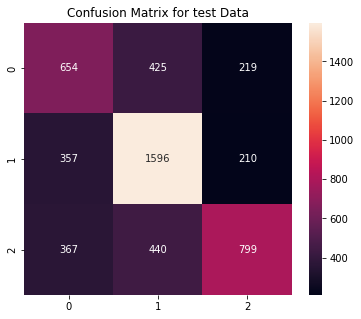

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for test Data')
plt.show()

Comparing the results of phase three with phase two and phase one.

|               | Phase One | Phase Two | Phase Three |
|---------------|-------------|-------------|-------------|
| Test Accuracy | 40.04 % | 58.97 % | 60.17 % |
| Test F1 Score | 40.04 % | 58.97 % | 60.17 % |

### Section 2: First Try - SOTA Pre-trained Transformer Backbones Fine-Tuning (ViLT)
 **(Not Accurate Enough, Don't Run Again, Second Try is Better, Run That)**

In this part of the project, we must use a SOTA transformer for multi-model task classification. For first try, we decide to implement the ViLT, which is a vision-and-language transformer without convolution or region supervision. ViLT incorporates text embeddings into a Vision Transformer (ViT), allowing it to have a minimal design for Vision-and-Language Pre-training (VLP). According to the paper, results demonstrate that ViLT is up to tens of times faster than previous VLP models, yet with competitive or better downstream task performance. ViLT is a model that takes both pixel_values and input_ids as input. One can use Vilt-processor to prepare data for the model. This processor wraps a feature extractor (for the image modality) and a tokenizer (for the language modality) into one.

In [ ]:
# setting the device to cuda if available
torch.backends.cudnn.deterministic = True  # cuda algorithms
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### Section 2.1: Prepare Data for Multimodal Transformer (ViLT)

Firstly, in this part of the project, we add a new mode to our custom data-loader. In SOTA get_mode, we obtain an encoding vector as output, which has an image and text encoded to the form of ViLT input with ViLT processor function and a column of sentiment label. 

In [ ]:
# load ViLT processor from hugging face to process image and text
ViLT_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
# Instantiate a MSCTD object for each part of the dataset.
train_data = MSCTD(data_path='./data', partition='train', get_mode='SOTA',transform = (T.Resize([384,384])),Auto_Processor=ViLT_processor)
dev_data = MSCTD(data_path='./data', partition='dev', get_mode='SOTA',transform = (T.Resize([384,384])),Auto_Processor=ViLT_processor)
test_data = MSCTD(data_path='./data', partition='test', get_mode='SOTA',transform = (T.Resize([384,384])),Auto_Processor=ViLT_processor)

Define a Data_padding function to pad each image with image_processor function. This function output is input_ids, attention_mask, token_type_ids for utterence text and pixel_values, pixel_mask for each image.

In [ ]:
def Data_padding_function(Data):
  
  input_ids = [item['input_ids'] for item in Data]
  pixel_values = [item['pixel_values'] for item in Data]
  attention_mask = [item['attention_mask'] for item in Data]
  token_type_ids = [item['token_type_ids'] for item in Data]
  sentiment_label = [item['sentiment_label'] for item in Data]
  
  # create padded pixel values and corresponding pixel mask
  encoding = ViLT_processor.image_processor.pad(pixel_values, return_tensors="pt")
  
  # create new batch of data for input to model
  Padding_Data = {}
  Padding_Data['input_ids'] = torch.stack(input_ids)
  Padding_Data['attention_mask'] = torch.stack(attention_mask)
  Padding_Data['token_type_ids'] = torch.stack(token_type_ids)
  Padding_Data['pixel_values'] = encoding['pixel_values']
  Padding_Data['pixel_mask'] = encoding['pixel_mask']
  # create a tensor for true labels
  true_label = torch.stack(sentiment_label)
  
  return Padding_Data, true_label

Load train, dev and test data with pytorch dataloader, according to the desired batch size to prevent ram and gpu crash. Set batch size to 32 fit GPU to the maximum value and algorithm didn,t crash.

Also shape of one sample batch of train data shown below.

In [ ]:
Batch_size = 32
# load all data with pytorch dataloader   
train_data_loader = DataLoader(train_data, batch_size=Batch_size, shuffle=True ,collate_fn=Data_padding_function)
dev_data_loader = DataLoader(dev_data, batch_size=Batch_size, shuffle=True,collate_fn=Data_padding_function)
test_data_loader = DataLoader(test_data, batch_size=Batch_size, shuffle=False,collate_fn=Data_padding_function)

# shape of one Sample batch of train data
Padding_Data ,true_label= next(iter(train_data_loader))
print("True_label ",true_label.shape)
print("-------------------------------------")

for key,value in Padding_Data.items():
  print(key, value.shape)
  print("-------------------------------------")

True_label  torch.Size([32])
-------------------------------------
input_ids torch.Size([32, 20])
-------------------------------------
attention_mask torch.Size([32, 20])
-------------------------------------
token_type_ids torch.Size([32, 20])
-------------------------------------
pixel_values torch.Size([32, 3, 384, 384])
-------------------------------------
pixel_mask torch.Size([32, 384, 384])
-------------------------------------


#### Section 2.2: Load ViLT Transformer and Create a classifier

Load the Vilt model from the hugging face and then add two classifier layers to the output of the pooler_output. Then set all parameters requires_grad True to be updated throw fine-tunning.

In [ ]:
class Classifier_ViLT(nn.Module):
    def __init__(self):
        super(Classifier_ViLT, self).__init__()
         # Load pre-trained ViLT model from Hugging Face model hub
        self.ViLT_pre_trained =  ViltModel.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
        self.Do1 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(768,64)
        self.relu1 = nn.ReLU()
        self.Do2 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(64,3)
        self.softmax = nn.Softmax(dim=1)

        # weights initialization with xavier method
        nn.init.xavier_uniform_(self.linear1.weight) 
        nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_uniform_(self.linear2.weight) 
        nn.init.zeros_(self.linear2.bias)
    
    def forward(self, input_ids, attention_mask, token_type_ids, pixel_values, pixel_mask):
        output = self.ViLT_pre_trained(input_ids = input_ids, attention_mask = attention_mask,
                                token_type_ids= token_type_ids, pixel_values =pixel_values, pixel_mask=pixel_mask)
        
        output = output.pooler_output
        output = self.Do1(output)
        output = self.linear1(output)
        output = self.relu1(output)
        output = self.Do2(output)
        output = self.linear2(output)
        logits = self.softmax(output)
        return logits

# Build model and make to device
ViLT_model_fine_tune = Classifier_ViLT()
ViLT_model_fine_tune.to(device)

for param in ViLT_model_fine_tune.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at dandelin/vilt-b32-finetuned-vqa were not used when initializing ViltModel: ['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.1.weight', 'classifier.3.bias', 'classifier.1.bias']
- This IS expected if you are initializing ViltModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViltModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size_train = len(dataloader.dataset)
    train_Loss, train_Correct = 0, 0
    model.train()
    for Padding_Data, true_label in tqdm(dataloader):
        # get the inputs; 
        inputs = {k:v.to(device) for k,v in Padding_Data.items()}
        True_labels = true_label.to(device)

        # Compute logits of model  
        pred = model(**inputs)

        # Compute loss 
        loss = loss_fn(pred, True_labels)
  
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_Loss += loss_fn(pred, True_labels).item()
        train_Correct += (pred.argmax(1) == True_labels).type(torch.float).sum().item()

    train_Loss /= size_train
    train_Correct /= size_train
    print(f" Train Error : Accuracy = {(100*train_Correct):>0.1f}%, Avg loss = {train_Loss:>8f} \n")


def test_loop(dataloader, model, loss_fn):
    Test_size = len(dataloader.dataset)
    test_Loss, Test_Correct = 0, 0
    model.eval()
    with torch.no_grad():
      for Padding_Data, true_label in tqdm(dataloader):
          # get the inputs; 
          inputs = {k:v.to(device) for k,v in Padding_Data.items()}
          True_labels = true_label.to(device)

          # Compute logits of model  
          pred = model(**inputs)

          # Compute loss 
          loss = loss_fn(pred, True_labels)

          test_Loss += loss_fn(pred, True_labels).item()
          Test_Correct += (pred.argmax(1) == True_labels).type(torch.float).sum().item()

    test_Loss /= Test_size
    Test_Correct /= Test_size
    print(f" Test Error : Accuracy = {(100*Test_Correct):>0.1f}%, Avg loss = {test_Loss:>8f} \n")

Fine-tune classifier model with Adam optimizer.

In [ ]:
# Set Hyperparameters of training
Epochs = 3
lr = 5e-5
# Use Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, ViLT_model_fine_tune.parameters()), lr=lr)
# Training
for epoch in range(Epochs):
    print(f" Epoch {epoch+1} -------------------------------")
    train_loop(train_data_loader, ViLT_model_fine_tune, loss_fn, optimizer)
    test_loop(dev_data_loader, ViLT_model_fine_tune, loss_fn)
print("Done!")

 Epoch 1 -------------------------------


100%|██████████| 633/633 [17:01<00:00,  1.61s/it]


 Train Error : Accuracy = 76.2%, Avg loss = 0.024597 



100%|██████████| 159/159 [02:39<00:00,  1.01s/it]


 Test Error : Accuracy = 54.2%, Avg loss = 0.031342 

 Epoch 2 -------------------------------


100%|██████████| 633/633 [16:58<00:00,  1.61s/it]


 Train Error : Accuracy = 78.8%, Avg loss = 0.023806 



100%|██████████| 159/159 [02:38<00:00,  1.00it/s]


 Test Error : Accuracy = 54.8%, Avg loss = 0.031138 

 Epoch 3 -------------------------------


100%|██████████| 633/633 [17:01<00:00,  1.61s/it]


 Train Error : Accuracy = 80.9%, Avg loss = 0.023149 



100%|██████████| 159/159 [02:40<00:00,  1.01s/it]

 Test Error : Accuracy = 53.8%, Avg loss = 0.031495 

Done!


#### Section 2.3: Save and load fine-tuned model
Before loading fine-tuned model, it's necessary to run the Classifier_Clip function first to load the structure of the Clip transformer (because the pre-trained model load in Classifier_Clip function). Then you can load fine-tune model to overwrite it.

In [ ]:
# saving
torch.save(ViLT_model_fine_tune, '/content/ViLT_model_fine_tune_Adam.pth')

In [ ]:
#Downloading trained MLP model from drive 
!gdown 10EcpAiyxTf3PxMrxt0oo0qzfLCkn696S
# loading model
ViLT_model_fine_tune_Adam= torch.load("/content/ViLT_model_fine_tune_Adam.pth")
ViLT_model_fine_tune_Adam.eval()

Downloading...
From: https://drive.google.com/uc?id=10EcpAiyxTf3PxMrxt0oo0qzfLCkn696S
To: /content/ViLT_model_fine_tune_Adam.pth
100% 447M/447M [00:03<00:00, 132MB/s]


Classifier_ViLT(
  (ViLT_pre_trained): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0): ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, ou

#### Section 2.4: Model Evaluation

Define a evaluation function to evaluate model on test data.

In [ ]:
def Evaluation_func(dataloader, model):
    Pred_label = []
    True_label = []
    model.eval()
    with torch.no_grad():
      for Padding_Data, true_label in tqdm(dataloader):
          # get the inputs; 
          inputs = {k:v.to(device) for k,v in Padding_Data.items()}
          True_labels = true_label.to(device)

          # Compute logits of model  
          pred = model(**inputs)

          # get true label and predicate label
          label = True_labels.cpu().numpy()
          True_label.extend(label)
          pred_label = pred.argmax(1).cpu().numpy()
          Pred_label.extend(pred_label)

    return True_label, Pred_label

100%|██████████| 159/159 [02:47<00:00,  1.06s/it]

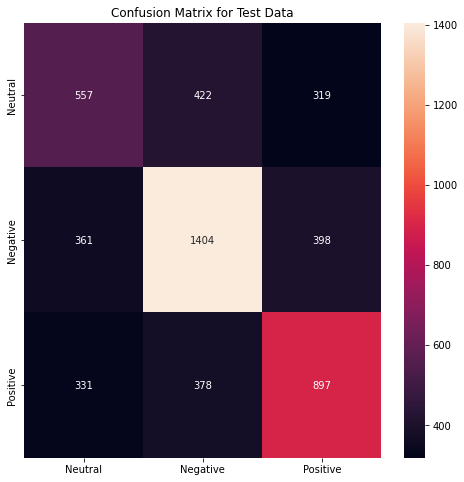




Test Accuracy: 56.40 %
Test Precision: 56.40 %
Test Recall: 56.40 %
Test F1-score: 56.40 %


In [ ]:
True_label, Pred_label = Evaluation_func(test_data_loader, ViLT_model_fine_tune_Adam)
print("\n")
test_acc = accuracy_score(True_label, Pred_label)
test_prc = precision_score(True_label, Pred_label, average='micro')
test_rcl = recall_score(True_label, Pred_label, average='micro')
test_F1 = f1_score(True_label, Pred_label, average='micro')

test_cf = confusion_matrix(True_label, Pred_label)

classes=["Neutral", "Negative", "Positive"]

plt.figure(figsize=(8, 8))
sns.heatmap(test_cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()
print("\n\n")
print(f"Test Accuracy: {test_acc*100:.2f} %")
print(f"Test Precision: {test_prc*100:.2f} %")
print(f"Test Recall: {test_rcl*100:.2f} %")
print(f"Test F1-score: {test_F1*100:.2f} %")

### Section 2: Second Try - SOTA Pre-trained Transformer Backbones Fine-Tuning (Clip)

For Second Try, we decide to implement the CLIP (Contrastive Language-Image Pre-Training), which is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3. CLIP uses a ViT like transformer to get visual features and a causal language model to get the text features. Both the text and visual features are then projected to a latent space with identical dimension. The dot product between the projected image and text features is then used as a similar score.

In [ ]:
# setting the device to cuda if available
torch.backends.cudnn.deterministic = True  # cuda algorithms
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### Section 2.1: Prepare Data for Multimodal Transformer (Clip)

Firstly, in this part of the project, we add a new mode to our custom data-loader. In SOTA get_mode, we obtain an encoding vector as output, which has an image and text encoded to the form of Clip input with Clip processor function and a column of sentiment label. 

In [ ]:
# load CLIP processor from hugging face to process image and text.
Clip_processor = CLIPProcessor.from_pretrained("flax-community/clip-rsicd-v2")
# Instantiate a MSCTD object for each part of the dataset.
train_data = MSCTD(data_path='./data', partition='train', get_mode='SOTA',transform = (T.Resize([224,224])),Auto_Processor=Clip_processor)
dev_data = MSCTD(data_path='./data', partition='dev', get_mode='SOTA',transform = (T.Resize([224,224])),Auto_Processor=Clip_processor)
test_data = MSCTD(data_path='./data', partition='test', get_mode='SOTA',transform = (T.Resize([224,224])),Auto_Processor=Clip_processor)

Define a Data_padding function to pad each image with image_processor function. This function output is input_ids and attention_mask for utterence text and pixel_values for each images.

In [ ]:
def Data_padding_function(Data):
  
  input_ids = [item['input_ids'] for item in Data]
  pixel_values = [item['pixel_values'] for item in Data]
  attention_mask = [item['attention_mask'] for item in Data]
  sentiment_label = [item['sentiment_label'] for item in Data]
  
  # create padded pixel values and corresponding pixel mask
  encoding = Clip_processor.image_processor(pixel_values, return_tensors="pt")
  
  # create new batch of data for input to model
  Padding_Data = {}
  Padding_Data['input_ids'] = torch.stack(input_ids)
  Padding_Data['attention_mask'] = torch.stack(attention_mask)
  Padding_Data['pixel_values'] = encoding['pixel_values']
  # create a tensor for true labels
  true_label = torch.stack(sentiment_label)
  
  return Padding_Data, true_label

Load train, dev and test data with pytorch dataloader, according to the desired batch size to prevent ram and gpu crash. Set batch size to 64 fit GPU to the maximum value and algorithm didn,t crash.

Also shape of one sample batch of train data shown below.

In [ ]:
Batch_size = 64
# load all data with pytorch dataloader   
train_data_loader = DataLoader(train_data, batch_size=Batch_size, shuffle=True ,collate_fn=Data_padding_function)
dev_data_loader = DataLoader(dev_data, batch_size=Batch_size, shuffle=True,collate_fn=Data_padding_function)
test_data_loader = DataLoader(test_data, batch_size=Batch_size, shuffle=False,collate_fn=Data_padding_function)

# shape of one Sample batch of train data
Padding_Data ,true_label= next(iter(train_data_loader))
print("True_label ",true_label.shape)
print("-------------------------------------")

for key,value in Padding_Data.items():
  print(key, value.shape)
  print("-------------------------------------")

True_label  torch.Size([64])
-------------------------------------
input_ids torch.Size([64, 25])
-------------------------------------
attention_mask torch.Size([64, 25])
-------------------------------------
pixel_values torch.Size([64, 3, 224, 224])
-------------------------------------


#### Section 2.2: Load Clip Transformer and Create a classifier

Load the Clip model from the hugging face and then add two classifier layers to the concatenate output of the vision_model and text_model pooler_output. Then set all parameters requires_grad True to be updated throw fine-tunning.

In [ ]:
class Classifier_Clip(nn.Module):
    def __init__(self):
        super(Classifier_Clip, self).__init__()
         # Load pre-trained CLIP model from Hugging Face model hub
        self.Clip_pre_trained = CLIPModel.from_pretrained("flax-community/clip-rsicd-v2")
        self.Do1 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(512+768,128)
        self.relu1 = nn.ReLU()
        self.Do2 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(128,3)
        self.softmax = nn.Softmax(dim=1)

        # weights initialization with xavier method
        nn.init.xavier_uniform_(self.linear1.weight) 
        nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_uniform_(self.linear2.weight) 
        nn.init.zeros_(self.linear2.bias)
    
    def forward(self, input_ids, attention_mask,  pixel_values):
        output = self.Clip_pre_trained(input_ids = input_ids, attention_mask = attention_mask,
                                 pixel_values =pixel_values)
        
        output_vision = output.vision_model_output.pooler_output
        output_text = output.text_model_output.pooler_output
        output_concat = torch.cat([output_vision,output_text], dim=1)
        output = self.Do1(output_concat)
        output = self.linear1(output)
        output = self.relu1(output)
        output = self.Do2(output)
        output = self.linear2(output)
        logits = self.softmax(output)
        return logits

# Build model and make to device
Clip_model_fine_tune = Classifier_Clip()
Clip_model_fine_tune.to(device)

for param in Clip_model_fine_tune.parameters():
    param.requires_grad = True

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size_train = len(dataloader.dataset)
    train_Loss, train_Correct = 0, 0
    model.train()
    for Padding_Data, true_label in tqdm(dataloader):
        # get the inputs; 
        inputs = {k:v.to(device) for k,v in Padding_Data.items()}
        True_labels = true_label.to(device)

        # Compute logits of model  
        pred = model(**inputs)

        # Compute loss 
        loss = loss_fn(pred, True_labels)
  
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_Loss += loss_fn(pred, True_labels).item()
        train_Correct += (pred.argmax(1) == True_labels).type(torch.float).sum().item()

    train_Loss /= size_train
    train_Correct /= size_train
    print(f" Train Error : Accuracy = {(100*train_Correct):>0.1f}%, Avg loss = {train_Loss:>8f} \n")


def test_loop(dataloader, model, loss_fn):
    Test_size = len(dataloader.dataset)
    test_Loss, Test_Correct = 0, 0
    model.eval()
    with torch.no_grad():
      for Padding_Data, true_label in tqdm(dataloader):
          # get the inputs; 
          inputs = {k:v.to(device) for k,v in Padding_Data.items()}
          True_labels = true_label.to(device)

          # Compute logits of model  
          pred = model(**inputs)

          # Compute loss 
          loss = loss_fn(pred, True_labels)

          test_Loss += loss_fn(pred, True_labels).item()
          Test_Correct += (pred.argmax(1) == True_labels).type(torch.float).sum().item()

    test_Loss /= Test_size
    Test_Correct /= Test_size
    print(f" Test Error : Accuracy = {(100*Test_Correct):>0.1f}%, Avg loss = {test_Loss:>8f} \n")

Fine-tune classifier model with Adam optimizer.

In [ ]:
# Set Hyperparameters of training
Epochs = 10
lr = 5e-6
# Use Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, Clip_model_fine_tune.parameters()), lr=lr)
# Training
for epoch in range(Epochs):
    print(f" Epoch {epoch+1} -------------------------------")
    train_loop(train_data_loader, Clip_model_fine_tune, loss_fn, optimizer)
    test_loop(dev_data_loader, Clip_model_fine_tune, loss_fn)
print("Done!")

 Epoch 1 -------------------------------


100%|██████████| 317/317 [09:15<00:00,  1.75s/it]


 Train Error : Accuracy = 55.4%, Avg loss = 0.015256 



100%|██████████| 80/80 [01:35<00:00,  1.19s/it]


 Test Error : Accuracy = 59.6%, Avg loss = 0.014919 

 Epoch 2 -------------------------------


100%|██████████| 317/317 [08:42<00:00,  1.65s/it]


 Train Error : Accuracy = 65.4%, Avg loss = 0.013919 



100%|██████████| 80/80 [01:27<00:00,  1.09s/it]


 Test Error : Accuracy = 59.9%, Avg loss = 0.014852 

 Epoch 3 -------------------------------


100%|██████████| 317/317 [08:30<00:00,  1.61s/it]


 Train Error : Accuracy = 70.1%, Avg loss = 0.013201 



100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


 Test Error : Accuracy = 59.4%, Avg loss = 0.014861 

 Epoch 4 -------------------------------


100%|██████████| 317/317 [08:30<00:00,  1.61s/it]


 Train Error : Accuracy = 74.8%, Avg loss = 0.012531 



100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


 Test Error : Accuracy = 59.2%, Avg loss = 0.014935 

 Epoch 5 -------------------------------


100%|██████████| 317/317 [08:32<00:00,  1.62s/it]


 Train Error : Accuracy = 77.5%, Avg loss = 0.012110 



100%|██████████| 80/80 [01:27<00:00,  1.09s/it]


 Test Error : Accuracy = 58.9%, Avg loss = 0.015030 

 Epoch 6 -------------------------------


100%|██████████| 317/317 [08:31<00:00,  1.61s/it]


 Train Error : Accuracy = 80.4%, Avg loss = 0.011691 



100%|██████████| 80/80 [01:27<00:00,  1.09s/it]


 Test Error : Accuracy = 59.5%, Avg loss = 0.014915 

 Epoch 7 -------------------------------


100%|██████████| 317/317 [08:31<00:00,  1.61s/it]


 Train Error : Accuracy = 82.2%, Avg loss = 0.011404 



100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


 Test Error : Accuracy = 58.9%, Avg loss = 0.015062 

 Epoch 8 -------------------------------


100%|██████████| 317/317 [08:34<00:00,  1.62s/it]


 Train Error : Accuracy = 83.5%, Avg loss = 0.011202 



100%|██████████| 80/80 [01:26<00:00,  1.09s/it]


 Test Error : Accuracy = 59.6%, Avg loss = 0.014969 

 Epoch 9 -------------------------------


100%|██████████| 317/317 [09:06<00:00,  1.72s/it]


 Train Error : Accuracy = 84.7%, Avg loss = 0.011025 



100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


 Test Error : Accuracy = 59.5%, Avg loss = 0.015006 

 Epoch 10 -------------------------------


100%|██████████| 317/317 [08:33<00:00,  1.62s/it]


 Train Error : Accuracy = 85.8%, Avg loss = 0.010859 



100%|██████████| 80/80 [01:28<00:00,  1.11s/it]

 Test Error : Accuracy = 59.5%, Avg loss = 0.015007 

Done!


#### Section 2.3: Save and load fine-tuned model
Before loading fine-tuned model, it's necessary to run the Classifier_Clip function first to load the structure of the Clip transformer (because the pre-trained model load in Classifier_Clip function). Then you can load fine-tune model to overwrite it.

In [ ]:
# saving
torch.save(Clip_model_fine_tune, '/content/Clip_model_fine_tune.pth')

In [ ]:
#Downloading trained MLP model from drive 
!gdown 1QUdX8DiG2gogfJFEA2EGB7TyhUB8cr4N
# loading model
Clip_model_fine_tune= torch.load("/content/Clip_model_fine_tune.pth")
Clip_model_fine_tune.eval()

Downloading...
From: https://drive.google.com/uc?id=1QUdX8DiG2gogfJFEA2EGB7TyhUB8cr4N
To: /content/Clip_model_fine_tune.pth
100% 606M/606M [00:02<00:00, 211MB/s]


Classifier_Clip(
  (Clip_pre_trained): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0): CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=Tr

#### Section 2.4: Model Evaluation

Define a evaluation function to evaluate model on test data.

In [ ]:
def Evaluation_func(dataloader, model):
    Pred_label = []
    True_label = []
    model.eval()
    with torch.no_grad():
      for Padding_Data, true_label in tqdm(dataloader):
          # get the inputs; 
          inputs = {k:v.to(device) for k,v in Padding_Data.items()}
          True_labels = true_label.to(device)

          # Compute logits of model  
          pred = model(**inputs)

          # get true label and predicate label
          label = True_labels.cpu().numpy()
          True_label.extend(label)
          pred_label = pred.argmax(1).cpu().numpy()
          Pred_label.extend(pred_label)

    return True_label, Pred_label

100%|██████████| 80/80 [01:33<00:00,  1.17s/it]


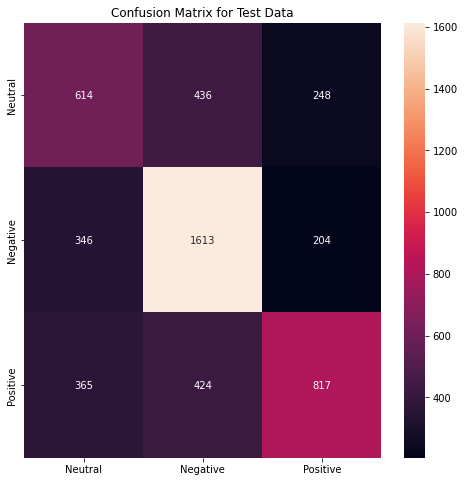




Test Accuracy: 60.07 %
Test Precision: 58.65 %
Test Recall: 57.58 %
Test F1-score: 57.75 %


In [ ]:
True_label, Pred_label = Evaluation_func(test_data_loader, Clip_model_fine_tune)

test_acc = accuracy_score(True_label, Pred_label)
test_prc = precision_score(True_label, Pred_label, average='macro')
test_rcl = recall_score(True_label, Pred_label, average='macro')
test_F1 = f1_score(True_label, Pred_label, average='macro')

test_cf = confusion_matrix(True_label, Pred_label)

classes=["Neutral", "Negative", "Positive"]

plt.figure(figsize=(8, 8))
sns.heatmap(test_cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()
print("\n\n")
print(f"Test Accuracy: {test_acc*100:.2f} %")
print(f"Test Precision: {test_prc*100:.2f} %")
print(f"Test Recall: {test_rcl*100:.2f} %")
print(f"Test F1-score: {test_F1*100:.2f} %")

####Comparision betwwen two method of multimodals models. 

- First we have concatenation method, which Accuracy and F1-score obtained 60.17%. 

- Second, we hava Clip transformer, which Accuracy and F1-score obtained 60.07% and 57.75%.


|  Phase Three  | Concatenation | SOTA (Clip) |
|---------------|---------------|-------------|
| Test Accuracy |    60.17 %    |    60.07 %  | 
| Test F1 Score |    60.17 %    |    57.75 %  | 

## Part 2: Weakly Supervised Learning

In this part, we use the validation part of the OpenViDial 1.0 dataset, which is a paired image-text dataset with no sentiment labels. The size of the validation part of this dataset is significantly larger than the whole MSCTD dataset.

In [ ]:
# Download OpenViDial 1.0 validation images.
!gdown 1J6YMq3Zwqdhi93IZFHi1JoS9xvcZcPfM
# Alternative method if the above failed.
# !gdown "1J6YMq3Zwqdhi93IZFHi1JoS9xvcZcPfM&confirm=t"

# Download OpenViDial 1.0 test images.
# !gdown 1DgZXlGi_x37nQrJYK4tSLXEvVShBKaZY

Downloading...
From: https://drive.google.com/uc?id=1J6YMq3Zwqdhi93IZFHi1JoS9xvcZcPfM&confirm=t
To: /content/valid_images.zip
100% 8.50G/8.50G [00:56<00:00, 151MB/s]


In [ ]:
# Download OpenViDial 1.0 validation utterances.
!gdown 1hVxtpTNcb3iOWt8NsDroihYtxOYhzsYz

# Download OpenViDial 1.0 test utterances.
# !gdown 1Rv6CFwDGwiVjozO5JXdiIXeVKmnJR1RL

Downloading...
From: https://drive.google.com/uc?id=1hVxtpTNcb3iOWt8NsDroihYtxOYhzsYz
To: /content/valid.origin.txt
100% 1.66M/1.66M [00:00<00:00, 218MB/s]


In [ ]:
# Unzip the validation images.
zip_ref = zipfile.ZipFile("./valid_images.zip", 'r')
zip_ref.extractall("./OpenViDial/Images")
zip_ref.close()

In [ ]:
# Move dialogues to the OpenViDial folder.
!mv /content/valid.origin.txt /content/OpenViDial/

In [ ]:
# Defining another custom dataloader class for OpenViDial dataset.
class OpenViDial(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None, shuffle=False, random_seed=None, get_mode='VD', pseudo_labels=None):
        self.data_path = data_path
        self.imgs_path = os.path.join(data_path, 'Images')
        self.utterance_path = os.path.join(data_path, 'valid.origin.txt')

        self.transform = transform
        self.shuffle = shuffle
        self.get_mode = get_mode
        self.pseudo_labels = pseudo_labels

        # Read the utterances.
        with open(self.utterance_path) as f:
            self.utterance = [line.rstrip('\n') for line in f]
        f.close()

        # Generate shuffling indices.
        rng = np.random.default_rng(seed=random_seed)
        
        self.shfl_idx_utt = np.arange(len(self.utterance))
        rng.shuffle(self.shfl_idx_utt)

    def __len__(self):
        return len(self.utterance)

    def __getitem__(self, idx):
        if self.shuffle:
            idx = self.shfl_idx_utt[idx]

        if self.get_mode == 'VD':
            img_path = os.path.join(self.imgs_path, str(idx)+'.jpg')
            image = read_image(img_path)
            utterance = self.utterance[idx]

            if self.transform:
                image = self.transform(image)

            return image, utterance

        elif self.get_mode == 'V':
            img_path = os.path.join(self.imgs_path, str(idx)+'.jpg')
            image = read_image(img_path)

            if self.transform:
                image = self.transform(image)

            return image

        elif self.get_mode == 'V+L':
            img_path = os.path.join(self.imgs_path, str(idx)+'.jpg')
            image = read_image(img_path)

            if self.transform:
                image = self.transform(image)

            return image, self.pseudo_labels[idx]

        elif self.get_mode == 'D':
            return self.utterance[idx]

        else:
            return None

In [ ]:
# Instantiate a OpenViDial dataset object.
unlabeled_data = OpenViDial('./OpenViDial/', get_mode='D')

### Generate Pseudo Labels

Now, We use our trained text sentiment classifier model to generate pseudo labels for the unlabeled dataset.

In [ ]:
# Setting the device to cuda if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
# Text sentiment classifier model class.
class BERT(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dense = nn.Linear(768, 3)

    def forward(self, input_id, mask):
        _, x = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = self.dense(x)

        return F.softmax(x, dim=1)

In [ ]:
# Download the trained model.
!gdown 1rXX6-7JkGv5nUa6G_TI88UlZlXE05ff2
model_bert = torch.load('./best_model_bert.h5', map_location=device)
# Freeze all parameters.
for p in model_bert.parameters():
  p.requires_grad = False

Downloading...
From: https://drive.google.com/uc?id=1rXX6-7JkGv5nUa6G_TI88UlZlXE05ff2
To: /content/best_model_bert.h5
100% 433M/433M [00:05<00:00, 74.8MB/s]


In [ ]:
# Define the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# Define a function to infer pseudo labels for the given dataset.
def InferPseudoLabels(dataloader, model, tokenizer):
    model.eval()
    pseudo_labels = torch.zeros(len(dataloader.dataset), 3)

    i = 0
    with torch.no_grad():
        for X in tqdm(dataloader):
            tokens = tokenizer(X, padding='max_length', max_length=17, truncation=True, return_tensors="pt")
            input_ids = tokens.input_ids.to(device)
            attention_mask = tokens.attention_mask.to(device)

            pseudo_labels[i*len(X):(i+1)*len(X), :] = model(input_ids, attention_mask)
            i += 1

    return pseudo_labels

In [ ]:
# Define a dataloader for the unlabeled dataset.
batch_size = 128
unlabeled_dataloader = DataLoader(unlabeled_data, batch_size=batch_size, num_workers=2)

In [ ]:
# Generate the pseudo labels.
pseudo_labels = InferPseudoLabels(unlabeled_dataloader, model_bert, tokenizer)

  0%|          | 0/435 [00:00<?, ?it/s]

### Train the Image Backbone With the Pseudo Labels

First, we need to download our trained image sentiment classifier from phase one, and then we can train its FC layer with the inferred pseudo labels.

In [ ]:
# Download the trained image model.
!gdown 1apY_I_gQX6OVZZxhkObB5GOqE7goNnW9

model_vit = torch.load("./model_based.h5", map_location=device)

Downloading...
From: https://drive.google.com/uc?id=1apY_I_gQX6OVZZxhkObB5GOqE7goNnW9
To: /content/model_based.h5
100% 344M/344M [00:02<00:00, 151MB/s]


In [ ]:
# Define the training loop.
def train_loop(dataloader, model, loss_fn, optimizer, epochs=(1, 1)):
    model.train()

    running_loss = 0
    loop = tqdm(enumerate(dataloader, 1), total=len(dataloader))
    loop.set_description(f'Epoch={epochs[0]}/{epochs[1]}')
    for batch, (X, y) in loop:
        X=(X/255).to(device)
        y=y.to(device)
        # Compute prediction and loss.
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        loop.set_postfix(Loss=str(round(running_loss/batch, 4)))


# Define the evaluation loop.
def eval_loop(dataloader, model, loss_fn, return_preds=False):
    model.eval()

    preds = torch.zeros(len(dataloader.dataset), 3)
    valid_loss = 0
    correct = 0
    total = 0

    loop = tqdm(dataloader)
    loop.set_description('Evaluation')
    with torch.no_grad():
        for X, _, y in loop:
            X=(X/255).to(device)
            y=y.to(device)

            # Compute prediction, loss and accuracy.
            pred = model(X)
            preds[total:total+len(X)] = pred
            valid_loss += loss_fn(pred, y).item() * len(X)
            correct += (pred.argmax(dim=1)==y).type(torch.float).sum().item()
            total += len(X)

            loop.set_postfix(Accuracy=correct/total, Loss=str(round(valid_loss/total, 4)))

    # Return all predictions.
    if return_preds:
        return preds

In [ ]:
# Define the image transform for our image model.
img_transforms = T.Resize([224, 224])

In [ ]:
# Set the required attributes for our dataset.
unlabeled_data.transform = img_transforms
unlabeled_data.pseudo_labels = pseudo_labels
unlabeled_data.get_mode = 'V+L'

# Define a dataloader for the unlabeled dataset.
batch_size = 128
unlabeled_dataloader = DataLoader(unlabeled_data, batch_size=batch_size, num_workers=2)

In [ ]:
# Set the image transform for MSCTD dataset.
train_data.transform = img_transforms
dev_data.transform = img_transforms
test_data.transform = img_transforms

# Create dataloaders.
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=2)
dev_dataloader = DataLoader(dev_data, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

In [ ]:
lr = 1e-6
epochs = 3

# Choose Adam optimizer.
optimizer = torch.optim.Adam(model_vit.parameters(), lr=lr)

# Define the loss function.
loss_fn = nn.CrossEntropyLoss()

# Training the image model with the pseudo labels.
for i in range(epochs):
    train_loop(unlabeled_dataloader, model_vit, loss_fn, optimizer, epochs=(i+1, epochs))
    eval_loop(dev_dataloader, model_vit, loss_fn)

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
# Save the trained model.
torch.save(model_vit, './model_vit_WeaklySupervised.h5')

In [ ]:
# Download the weakly supervised trained image model.
!gdown 1u9-8XjMEx-coZgLUDhII-PyBAy-DrNxB

model_vit = torch.load("./model_vit_WeaklySupervised.h5", map_location=device)

After this weak supervision learning, we now evaluate our image sentiment classifier on the MSCTD dataset.

In [ ]:
# Disable the shuffling.
train_dataloader = DataLoader(train_data, shuffle=False, batch_size=batch_size, num_workers=2)
# Predict the sentiment labels for the MSCTD dataset.
preds_train = eval_loop(train_dataloader, model_vit, loss_fn, return_preds=True)
preds_dev = eval_loop(dev_dataloader, model_vit, loss_fn, return_preds=True)
preds_test = eval_loop(test_dataloader, model_vit, loss_fn, return_preds=True)

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

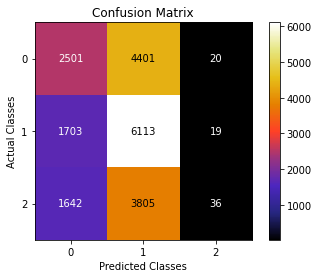


Train Accuracy: 0.42737154150197626
Train F1 Score (Macro): 0.3188597249673807


In [ ]:
# Train data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=train_data.sentiment_labels, predict_vector=preds_train.argmax(dim=1).numpy())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nTrain Accuracy: {accuracy_score(train_data.sentiment_labels, preds_train.argmax(dim=1))}")
print(f"Train F1 Score (Macro): {f1_score(train_data.sentiment_labels, preds_train.argmax(dim=1), average='macro')}")

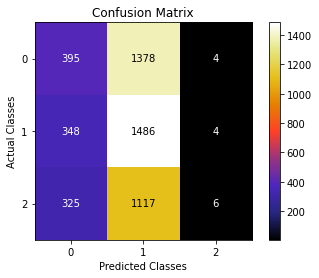


Dev Accuracy: 0.37270393047600237
Dev F1 Score (Macro): 0.26554291734211627


In [ ]:
# Dev data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=dev_data.sentiment_labels, predict_vector=preds_dev.argmax(dim=1).numpy())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nDev Accuracy: {accuracy_score(dev_data.sentiment_labels, preds_dev.argmax(dim=1))}")
print(f"Dev F1 Score (Macro): {f1_score(dev_data.sentiment_labels, preds_dev.argmax(dim=1), average='macro')}")

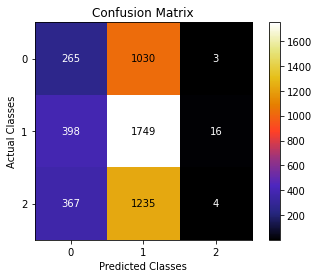


Test Accuracy: 0.39826327215314783
Test F1 Score (Macro): 0.2662895120689566


In [ ]:
# Test data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=test_data.sentiment_labels, predict_vector=preds_test.argmax(dim=1).numpy())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nTest Accuracy: {accuracy_score(test_data.sentiment_labels, preds_test.argmax(dim=1))}")
print(f"Test F1 Score (Macro): {f1_score(test_data.sentiment_labels, preds_test.argmax(dim=1), average='macro')}")

In [ ]:
# Test Data Statistics
print('***Test Data Statistics***')
print('-'*26)
cm.stat(summary=True)

***Test Data Statistics***
--------------------------
Overall Statistics : 

ACC Macro                                                         0.59884
F1 Macro                                                          0.26629
FPR Macro                                                         0.32947
Kappa                                                             0.01082
Overall ACC                                                       0.39826
PPV Macro                                                         0.28897
SOA1(Landis & Koch)                                               Slight
TPR Macro                                                         0.33842
Zero-one Loss                                                     3049

Class Statistics :

Classes                                                           0             1             2             
ACC(Accuracy)                                                     0.64515       0.47128       0.68009       
AUC(Area under the ROC

The following tables list the evaluation results of our image sentiment classifier both before and after the weak supervision.

**Before Weak Supervision (Phase One):**  

|                  | Train   | Dev     | Test    |
|------------------|---------|---------|---------|
| Accuracy         | 43.91 % | 36.22 % | 37.77 % |
| F1 Score (Macro) | 42.66 % | 35.19 % | 34.68 % |

**After Weak Supervision (Phase Three):**  

|                  | Train   | Dev     | Test    |
|------------------|---------|---------|---------|
| Accuracy         | 42.74 % | 37.27 % | 39.83 % |
| F1 Score (Macro) | 31.88 % | 26.55 % | 26.63 % |

As shown in the tables above, the dev and test accuracies slightly increased after the weak supervision by our text sentiment classifier. But we can see that the F1 score has significantly decreased. We can reach a balance between accuracy and F1 score by tuning the learning rate, number of epochs, and optimizer in weakly supervised learning.